In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import matplotlib.dates as mdates

## Загрузка сырых данных, очистка, сохранение ##

In [95]:
# Загрузка сырых данных из AppleHealth
data = pd.read_csv('data/Record.csv', low_memory=False)

# Очистка данных: сокращение имен в "type"
data['type'] = data['type'].str.replace('HKQuantityTypeIdentifier', '', regex=False) # .str

# Очистка данных: выбор интересующих "type"
need_lst = ['BodyMass', 'HeartRate', 'BodyFatPercentage',
            'StepCount', 'DistanceWalkingRunning', 'BasalEnergyBurned',
            'ActiveEnergyBurned', 'FlightsClimbed', 'DietaryFatTotal', 'DietaryCarbohydrates',
            'DietarySugar', 'DietaryEnergyConsumed', 'DietaryProtein',
            'oal', 'SleepAnalysis', 'Fatigue']
filtered_data = data[data['type'].isin(need_lst)]

# Очистка данных: удаление лишней информации и полных дубликатов
filtered_data = filtered_data[['type', 'value', 'unit', 'startDate', 'sourceName', 'HKFoodType']]
filtered_data = filtered_data.rename(columns={'startDate': 'date'}).reset_index(drop=True)
filtered_data = filtered_data.drop_duplicates(subset=['date', 'value', 'unit', 'type'])
# Удаление дубликатов StepCount
filtered_data = filtered_data[(filtered_data['type'] != 'StepCount') |
                              ((filtered_data['type'] == 'StepCount') & (filtered_data['sourceName'] == 'Zepp Life'))]

# Сохранение данных в новый файл
filtered_data.to_csv('data/Record_clear.csv', index=False)

## Работа с новым файлом

In [96]:
# Загрузка сырых данных из AppleHealth
data = pd.read_csv('data/Record_clear.csv', low_memory=False)
data.head()

,type,value,unit,date,sourceName,HKFoodType
0,BodyMass,73.30,kg,2024-11-16 10:13:59 +0300,Zepp Life,NaN
1,BodyMass,73.30,kg,2024-11-23 08:08:51 +0300,Zepp Life,NaN
2,BodyMass,73.50,kg,2024-11-26 07:59:42 +0300,Zepp Life,NaN
3,BodyMass,80.00,kg,2024-06-07 19:47:40 +0300,Zepp Life,NaN
4,BodyMass,77.95,kg,2024-06-16 00:00:34 +0300,Zepp Life,NaN


In [97]:
# Сколько таких повторов
dups = data[data['type'] == 'DietaryProtein'].duplicated(subset=['date', 'value', 'unit', 'type'])
print(f"Найдено дубликатов: {dups.sum()}")
dups

Найдено дубликатов: 0


1142069    False
1142070    False
1142071    False
1142072    False
1142073    False
           ...  
1148795    False
1148796    False
1148797    False
1148798    False
1148799    False
Length: 6731, dtype: bool

In [11]:
# Подходит под значения, где запись соответствует полным данным за день
# Данные тела: BodyMass, BodyFatPercentage

def mean_month_mass_visualize(type_id: str):
    # Создание копии df с нужным type
    filtered_data = data[data['type'] == type_id][['date', 'value']].copy()

    # Изменение формата даты и сортировка по ней
    filtered_data['date'] = pd.to_datetime(filtered_data['date'])
    filtered_data = filtered_data.sort_values('date').reset_index(drop=True)
    
    # Изменение формата данных на "среднее за месяц"
    filtered_data['date'] = filtered_data['date'].dt.to_period('M').astype(str) # изменение формата даты на месяцы и приведение к строке
    filtered_data = filtered_data.groupby(filtered_data['date'])['value'].mean().reset_index()
    
    # Создание графика
    plt.figure(figsize=(16, 9))
    plt.title(type_id)
    # Не во всех данных есть unit
    try:
        plt.ylabel(data[data['type'] == type_id]['unit'][0])
    except:
        pass
    plt.bar(filtered_data['date'], filtered_data['value'], color='blue')
    plt.ylim(filtered_data['value'].min()*0.9, filtered_data['value'].max()-1.1) # подстраивается под min и max значения в данных
    plt.xticks(rotation=75)
    plt.tight_layout() # подгоняет элементы к размеру фигуры
    plt.show()
    
    return filtered_data

C:\Users\spopo\AppData\Local\Temp\ipykernel_10428\2031242942.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_data['date'] = filtered_data['date'].dt.to_period('M').astype(str) # изменение формата даты на месяцы и приведение к строке


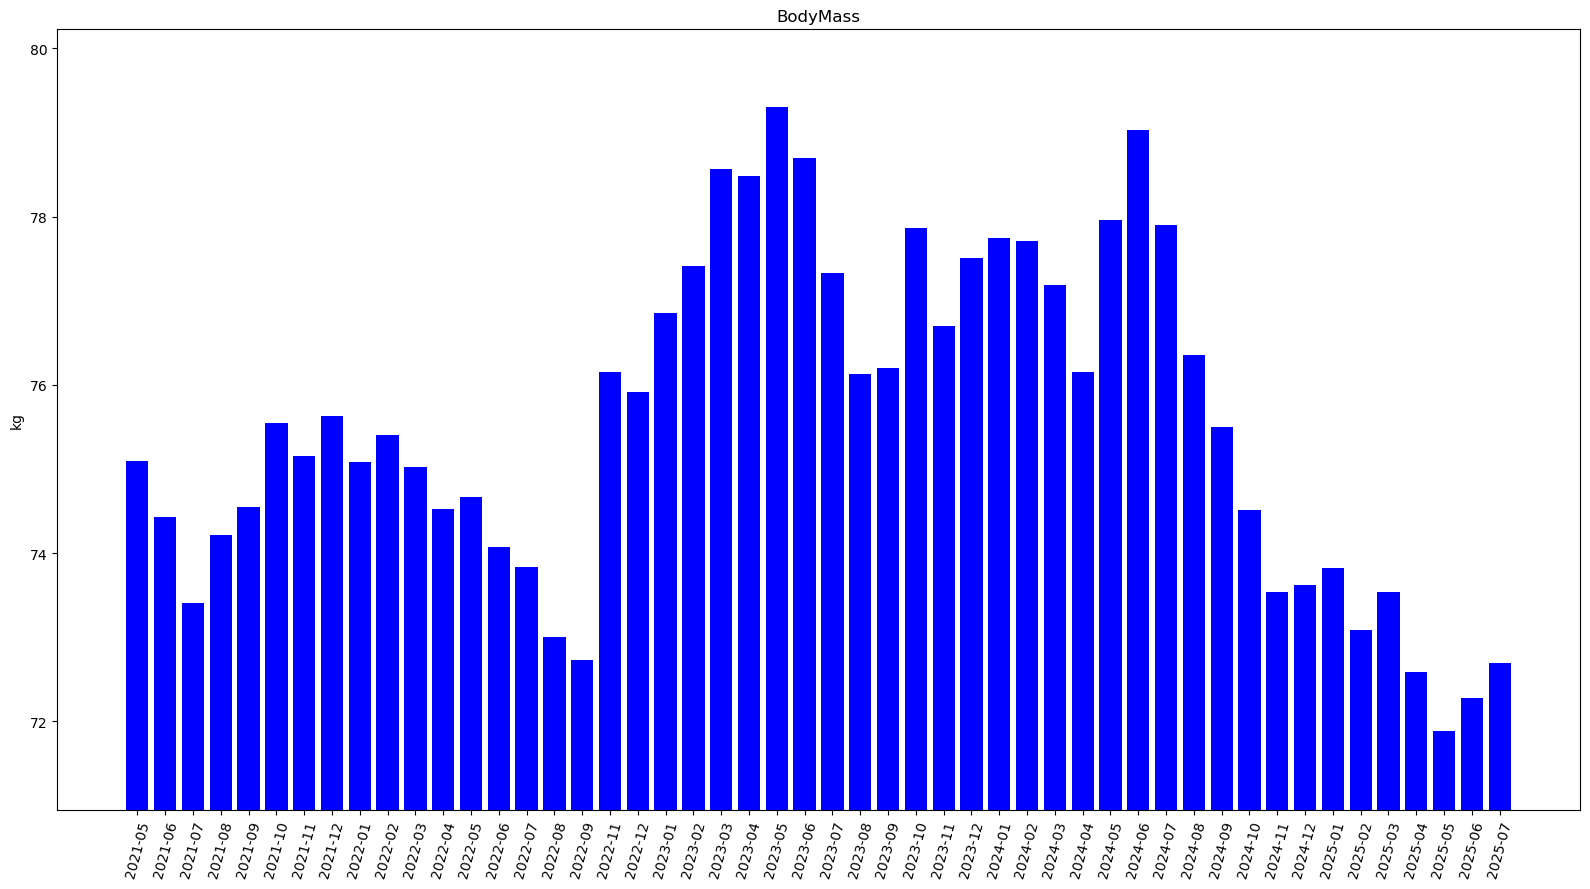

C:\Users\spopo\AppData\Local\Temp\ipykernel_10428\2031242942.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_data['date'] = filtered_data['date'].dt.to_period('M').astype(str) # изменение формата даты на месяцы и приведение к строке


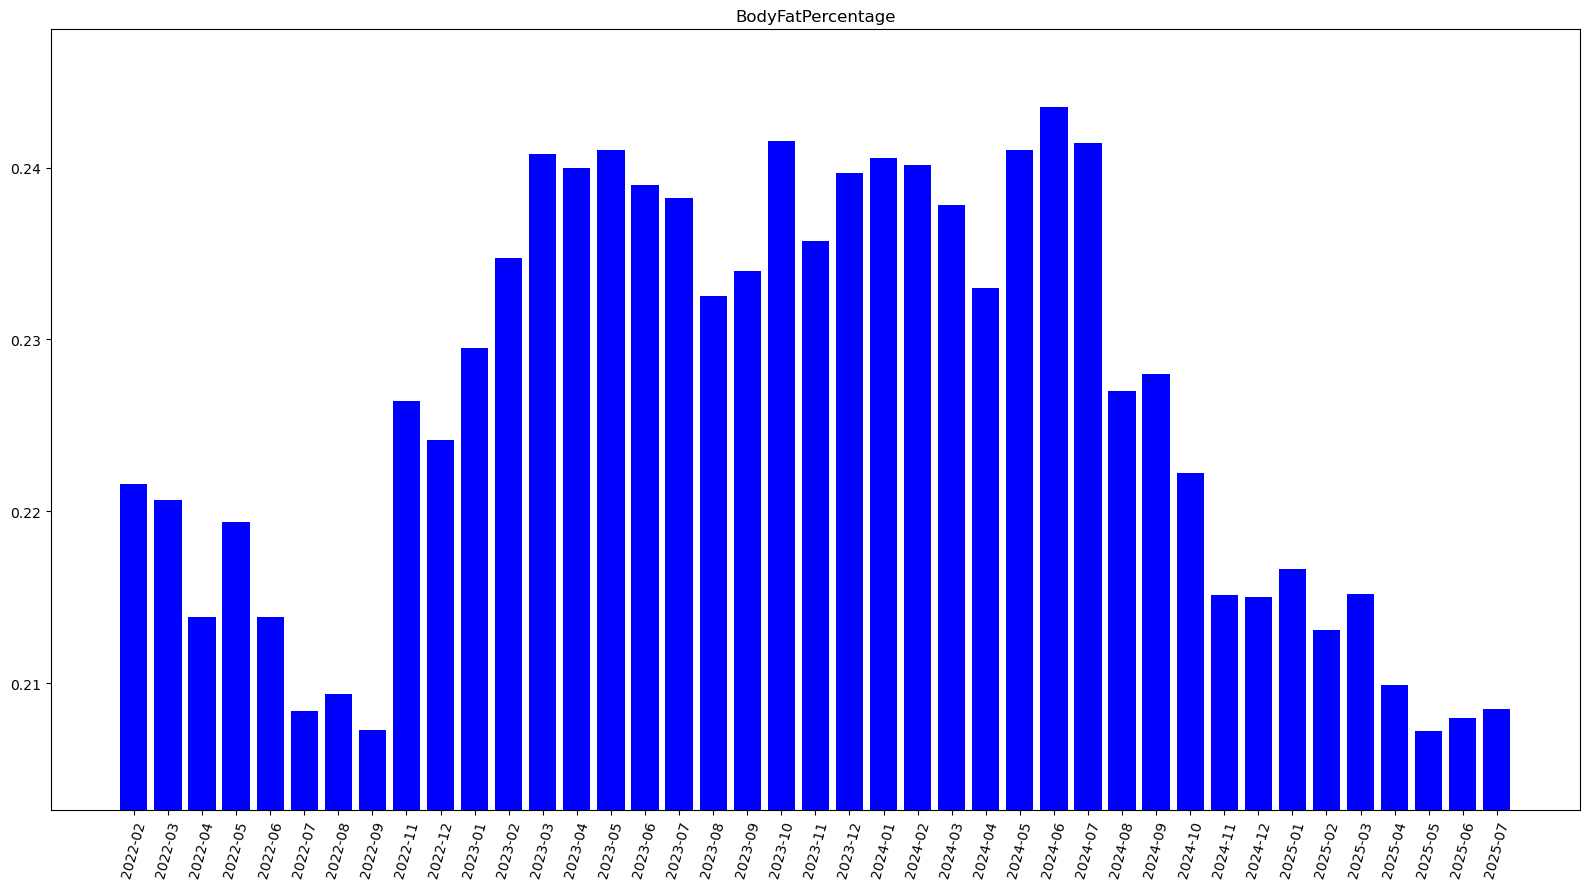

In [4]:
for i in ['BodyMass', 'BodyFatPercentage']:
    temp_df = mean_month_mass_visualize(i)

In [98]:
# Подходит под значения, где множество записей за день
# Активность: StepCount, DistanceWalkingRunning, BasalEnergyBurned, ActiveEnergyBurned, FlightsClimbed
# КБЖУ: DietaryEnergyConsumed, DietaryProtein, DietaryFatTotal, DietaryCarbohydrates

def mean_month_step_visualize(type_id: str):
    # Создание копии df с нужным type
    filtered_data = data[(data['type'] == type_id)].copy()

    # Изменение формата даты и сортировка по ней
    filtered_data['date'] = pd.to_datetime(filtered_data['date'])
    filtered_data = filtered_data.sort_values('date').reset_index(drop=True)

    # Изменение формата данных на "среднее за месяц"
    filtered_data = filtered_data.groupby(filtered_data['date'].dt.date)['value'].sum().reset_index() # агрегация по дате (дню), т.к. записей за день несколько
    filtered_data['date'] = pd.to_datetime(filtered_data['date'])  # возвращаем datetime, чтобы .dt работал

    filtered_data['date'] = filtered_data['date'].dt.to_period('M').astype(str) # изменение формата даты на месяцы и приведение к строке
    filtered_data = filtered_data.groupby(filtered_data['date'])['value'].mean().reset_index()
    
    # Создание графика
    plt.figure(figsize=(16, 9))
    plt.title(type_id)
    # Не во всех данных есть unit
    try:
        plt.ylabel(data[data['type'] == type_id]['unit'][0])
    except:
        pass
    
    #print(filtered_data['value'])
    plt.ylim(filtered_data['value'].min()*0.95, filtered_data['value'].max()*1.05) # подстраивается под min и max значения в данных
    plt.xticks(rotation=75)
    plt.tight_layout() # подгоняет элементы к размеру фигуры
    
    plt.bar(filtered_data['date'], filtered_data['value'], color='blue')
    plt.show()
    
    return filtered_data

ValueError: Axis limits cannot be NaN or Inf

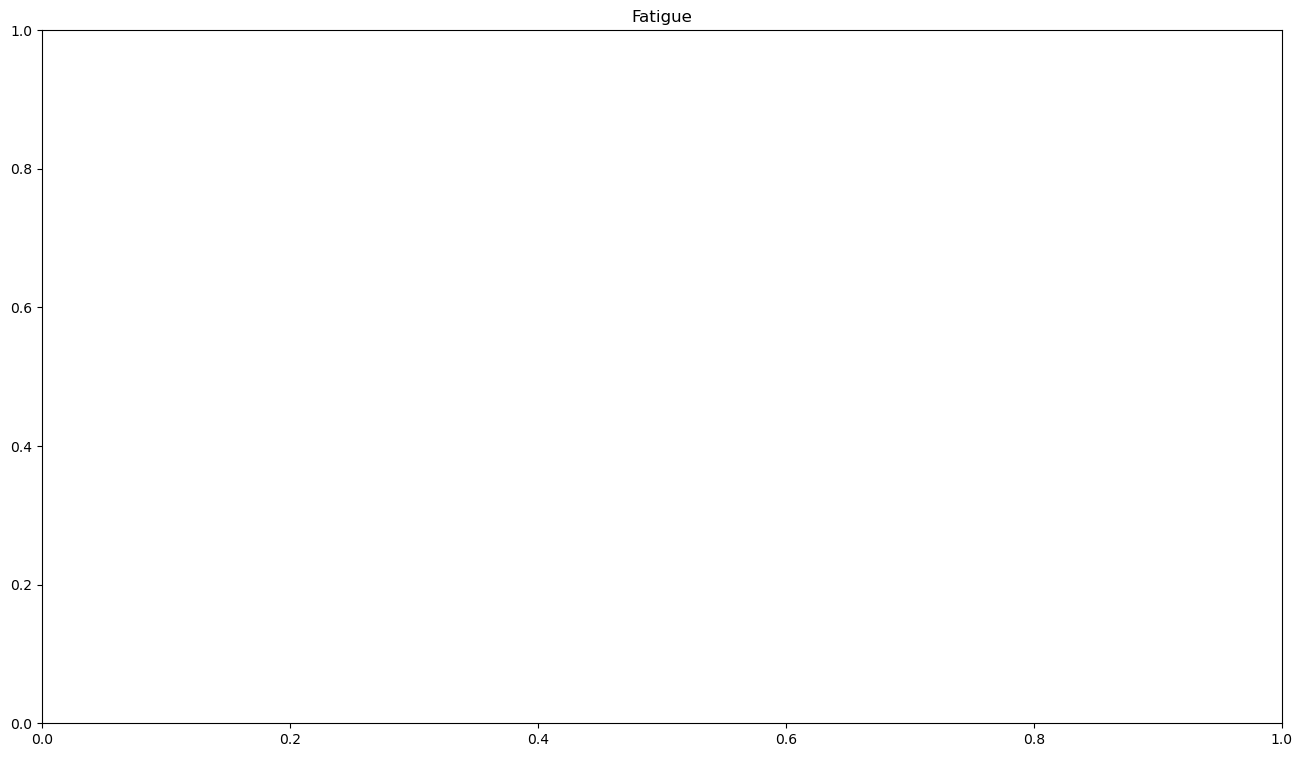

In [102]:
for i in ['Fatigue']:
    temp_df = mean_month_step_visualize(i)

In [76]:
walking_df = data[data['type'] == 'DietaryProtein']
walking_df['date'] = pd.to_datetime(walking_df['date'])
print(walking_df['sourceName'].unique())
walking_df = walking_df[walking_df['date'].dt.date == pd.to_datetime('2025-07-20').date()]
print(walking_df)
walking_df['value'].groupby(walking_df['sourceName']).sum()

['YAZIO']
                   type    value unit                      date sourceName  \
1235785  DietaryProtein  27.9528    g 2025-07-20 10:48:21+03:00      YAZIO   
1235786  DietaryProtein   5.7000    g 2025-07-20 10:48:25+03:00      YAZIO   
1235787  DietaryProtein  18.8700    g 2025-07-20 10:48:39+03:00      YAZIO   
1235788  DietaryProtein   3.0990    g 2025-07-20 10:48:54+03:00      YAZIO   
1235789  DietaryProtein   1.2600    g 2025-07-20 18:25:19+03:00      YAZIO   
1235790  DietaryProtein   0.1200    g 2025-07-20 18:25:20+03:00      YAZIO   
1235791  DietaryProtein  11.3200    g 2025-07-20 18:25:49+03:00      YAZIO   
1235792  DietaryProtein   3.8500    g 2025-07-20 18:25:54+03:00      YAZIO   
1235797  DietaryProtein  30.9600    g 2025-07-20 22:51:53+03:00      YAZIO   
1235798  DietaryProtein   2.8000    g 2025-07-20 22:52:05+03:00      YAZIO   
1235799  DietaryProtein   0.0000    g 2025-07-20 22:52:22+03:00      YAZIO   
1266224  DietaryProtein  27.9528    g 2025-07-20 10:48

C:\Users\spopo\AppData\Local\Temp\ipykernel_10428\2330234167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walking_df['date'] = pd.to_datetime(walking_df['date'])


sourceName
YAZIO    211.8636
Name: value, dtype: float64

In [60]:
data[data['type'] == 'StepCount']['value'].isna().unique()

array([False])

In [202]:
data[data['type'] == 'HKQuantityTypeIdentifierStepCount'][['startDate', 'value']]

,startDate,value
904015,2024-11-30 21:33:41 +0300,18.0
904016,2024-11-26 18:36:46 +0300,67.0
904017,2024-11-26 19:08:07 +0300,249.0
904018,2024-11-26 19:18:08 +0300,1188.0
904019,2024-11-26 19:28:09 +0300,377.0
...,...,...
1003187,2025-07-23 13:26:09 +0300,577.0
1003188,2025-07-23 13:49:02 +0300,23.0
1003189,2025-07-23 14:14:21 +0300,622.0
1003190,2025-07-23 14:49:40 +0300,16.0


C:\Users\spopo\AppData\Local\Temp\ipykernel_18724\3723178969.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['startDate'].dt.to_period('M').astype(str)


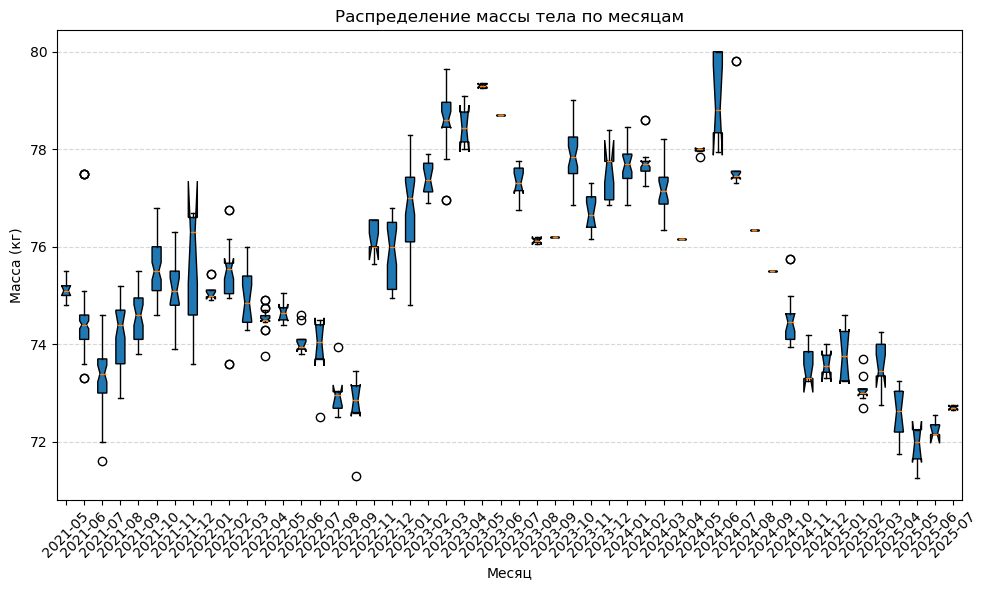

In [36]:
# Cell 3: создаём колонку с месяцем в формате YYYY‑MM
df['month'] = df['startDate'].dt.to_period('M').astype(str)

# Делаем список серий: по одному списку значений веса для каждого месяца
months = sorted(df['month'].unique())
groups = [df.loc[df['month'] == m, 'value'] for m in months]

# Cell 4: рисуем сам boxplot
plt.figure(figsize=(10, 6))
plt.boxlot(
    groups,
    labels=months,        # подписи по оси X
    notch=True,           # вырезы «ночи» (для оценки медианы)
    showfliers=True,      # показать выбросы как точки
    patch_artist=True     # закрасить коробки цветом
)
plt.title('Распределение массы тела по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Масса (кг)')
plt.xticks(rotation=45)   # повернуть подписи, чтобы не накладывались
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Объяснение и опции для изменения

df['month'] = df['startDate'].dt.to_period('M')
— превращает дату в период «месяц», например Period('2025-07', 'M'). С помощью .astype(str) получаем '2025-07'.

groups = […]
— список серий (каждый элемент — все измерения веса в данном месяце).

plt.boxplot(...)

notch=True рисует «выемку» вокруг медианы (помогает визуально оценить уровень доверия).

showfliers=False уберёт точки‑выбросы, если они мешают восприятию.

patch_artist=True позволяет залить «коробки» любым цветом (после можно задать box.set_facecolor('skyblue')).

Настройки внешнего вида

figsize=(ширина, высота) — меняет размер холста.

plt.grid(axis='y', ...) — добавляет горизонтальную сетку по оси Y.

rotation для наклона подписей, tight_layout() автоматически подгоняет поля.

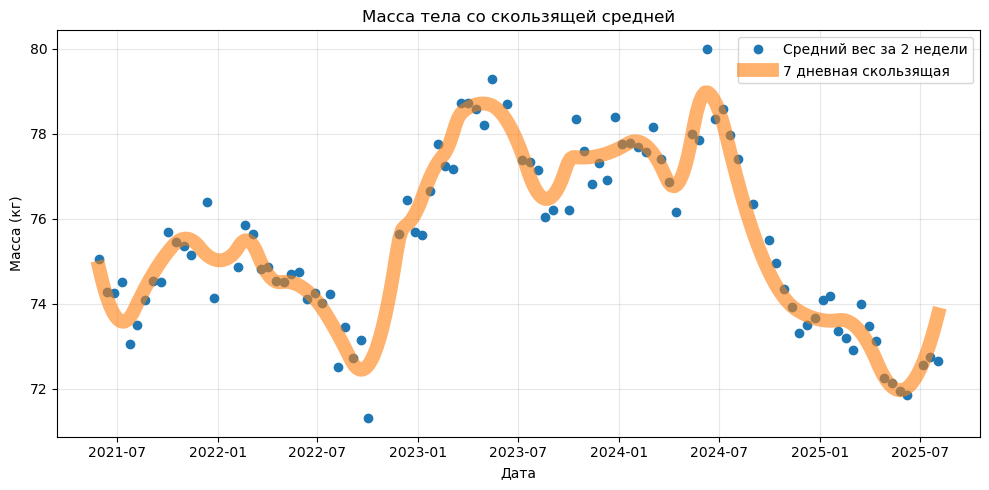

In [74]:
# 2. Агрегация — недельное среднее
weekly = (
    df
    .set_index('startDate')['value']
    .resample('2W')
    .mean()
    .dropna()
)

daily = (
    df
    .set_index('startDate')['value']
    .resample('7D')
    .mean()
    .dropna()
)

# 3. Конвертация дат в числовой формат для сплайна
x = mdates.date2num(weekly.index.to_pydatetime())
y = weekly.values

sx = mdates.date2num(daily.index.to_pydatetime())
sy = daily.values

# 4. Настройка и построение сплайна
#    Параметр s контролирует степень сглаживания:
#    больше s → более гладкая кривая
s_factor = len(x) * np.var(y) * 0.11
spline = UnivariateSpline(sx, sy, s=s_factor, k=2)

# 5. Генерация плотной сетки для гладкой линии
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x_smooth)
dates_smooth = mdates.num2date(x_smooth)

# 6. Визуализация
plt.figure(figsize=(10, 5))
plt.plot(weekly.index.to_pydatetime(), weekly.values, 'o', label='Средний вес за 2 недели')
plt.plot(dates_smooth, y_smooth, label='7 дневная скользящая', linewidth=10, alpha=0.6)
plt.title('Масса тела со скользящей средней')
plt.xlabel('Дата')
plt.ylabel('Масса (кг)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Разница и варианты

resample('7D').mean() будет делить всю шкалу времени на непересекающиеся 7‑дневные «корзины» и считать среднее в каждой.

rolling(window='7D') берёт «скользящее» окно шириной 7 дней для каждой точки на шкале: чаще получается более гладко и непрерывно.

Параметр window можно задавать в днях ('7D'), точках (window=7) или комбинированно (window='2W' для 2 недель).

По умолчанию .rolling(...).mean() включает в окно и центральную точку; есть опция center=True, чтобы окно «центрировалось» вокруг даты, а не «сдвигалось назад».